First attempt at modeling with data set after inital EDA.

In [1]:
# imports - basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# imports modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [2]:
# read in EDA cleaned file
df = pd.read_csv('../CommentFiles/Comments_EDA_Final.csv')

In [3]:
# check dataframe
df.head()

,subreddit,body,created_utc,author,submission_title
0,sportsbook,"fuck it, o64.5 1H",1616963381,dummyacct321,ncaabb_daily_discussion_32821_sunday
1,sportsbook,Look at this,1616963365,jtcarl,2021_mlb_betting_primer
2,sportsbook,"Toronto been baiting everyone all week, I’m st...",1616963335,hoooesay,nba_daily_discussion_32821_sunday
3,sportsbook,Fuck Michigan but today they make me money so ...,1616963310,Dont_Carry_it_All,ncaabb_daily_discussion_32821_sunday
4,sportsbook,"""follow if you feel like it""",1616963299,Feardamoo,which_is_the_worst_trend_on_sportsbook


In [4]:
# check classes
df['subreddit'].value_counts(normalize=True)

dfsports      0.501993
sportsbook    0.498007
Name: subreddit, dtype: float64

## Note: 
Dataframe looks like it is ready to model, classes are still 50/50 split.
Steps in modeling process:
1. Convert subreddit into binary labels.
2. Set up X, y variables and split the data into training and testing sets.
3. Pre-processing, use countvectorizer to convert text data into structed, numeric X dataframe.
4. Fit and tranform the vectorized text.
5. Check for top occuring words and continue some EDA.
6. Create stop words list.
7. Model using logistic regression.

In [5]:
# convert subreddit into binary labels
df['subreddit'] = df['subreddit'].map({'sportsbook': 1, 'dfsports': 0})

In [6]:
# double check with head
df.head()

,subreddit,body,created_utc,author,submission_title
0,1,"fuck it, o64.5 1H",1616963381,dummyacct321,ncaabb_daily_discussion_32821_sunday
1,1,Look at this,1616963365,jtcarl,2021_mlb_betting_primer
2,1,"Toronto been baiting everyone all week, I’m st...",1616963335,hoooesay,nba_daily_discussion_32821_sunday
3,1,Fuck Michigan but today they make me money so ...,1616963310,Dont_Carry_it_All,ncaabb_daily_discussion_32821_sunday
4,1,"""follow if you feel like it""",1616963299,Feardamoo,which_is_the_worst_trend_on_sportsbook


In [7]:
# set X and y variables
X = df['body']
y = df['subreddit']

In [8]:
#TTS
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [9]:
# Instantiate CountVectorizer
cvec = CountVectorizer()

In [10]:
# Fit and transform data sets
X_train_cvec = cvec.fit_transform(X_train)

In [11]:
# transform test data
X_test_cvec = cvec.transform(X_test)

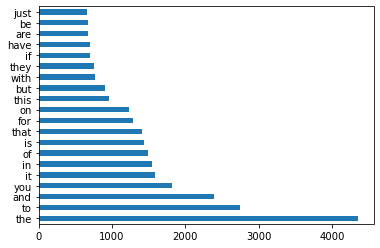

In [12]:
# check for top occuring words
# convert X_train to df
X_train_df = pd.DataFrame(X_train_cvec.todense(), columns=cvec.get_feature_names())
# plot top occuring words; top 20
X_train_df.sum().sort_values(ascending=False).head(20).plot(kind='barh');

## Annotation:
Top 20 occurring words seems to be very common words, found in sklearn's stopwords. From here I will reinstantiate count vectorizer with english stop words as stop words.

In [13]:
# reinstantiate countvectorizer
cvec = CountVectorizer(stop_words='english')

In [14]:
# Fit and transform data sets
X_train_cvec = cvec.fit_transform(X_train)

In [15]:
# transform test data
X_test_cvec = cvec.transform(X_test)

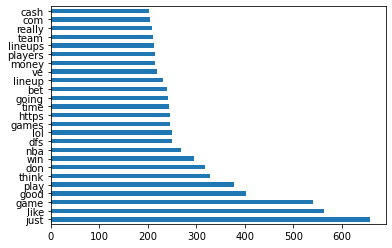

In [16]:
# check for top occuring words
# convert X_train to df
X_train_df = pd.DataFrame(X_train_cvec.todense(), columns=cvec.get_feature_names())
# plot top occuring words; top 20
X_train_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

### Need additional cleaning; https is in top 25.  Need to take out links and lol.

In [17]:
# model using logistic regression
logreg = LogisticRegression()

In [18]:
# fit model to countvectorized data sets
logreg.fit(X_train_cvec, y_train)

LogisticRegression()

In [19]:
# score train and test
print('Train Score: ', logreg.score(X_train_cvec, y_train))
print('Test Score : ', logreg.score(X_test_cvec, y_test))

Train Score:  0.953656462585034
Test Score :  0.8215423836838751


## Annotation:
Fairly good train score, but significantly higher than testing score.  Seems to be overfit at first glance.  Will use cross validation and confusion matrix as further indicates of models effectiveness.

In [20]:
# cross val score
cross_val_score(logreg, X_train_cvec, y_train, cv=5).mean()

0.8254683790444751

In [21]:
# accuracy score
y_preds = logreg.predict(X_test_cvec)
accuracy_score(y_test, y_preds)

0.8215423836838751

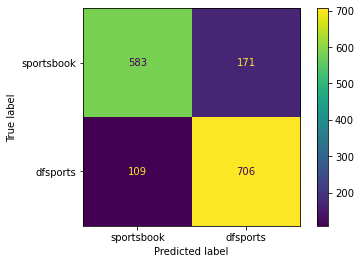

In [22]:
# confusion matrix, to plot and set values for further calculations
cm = confusion_matrix(y_test, y_preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm, display_labels=['sportsbook', 'dfsports']).plot();

In [23]:
# calculate the specificity, ability to pick true negatives
spec = tp/(tp+fn)
spec

0.8662576687116564

In [24]:
# calculate sensitivity, ability to pick out true positives
sens = tn/(tn+fp)
sens

0.773209549071618

Print classification report.

In [25]:
from sklearn.metrics import classification_report

In [26]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.77      0.81       754
           1       0.81      0.87      0.83       815

    accuracy                           0.82      1569
   macro avg       0.82      0.82      0.82      1569
weighted avg       0.82      0.82      0.82      1569



In [27]:
coef_df = pd.DataFrame(index=cvec.get_feature_names(), data=logreg.coef_[0], columns=['Coefficient Value'])

In [28]:
coef_df.sort_values(by='Coefficient Value', inplace=True)

In [29]:
coef_df.head(10)

,Coefficient Value
forwards,-2.678813
dfs,-2.647910
lineup,-2.568887
guards,-2.561716
center,-2.350453
lineups,-2.197801
entry,-1.635295
slate,-1.601113
congratulations,-1.553072
price,-1.551906


In [30]:
coef_df.tail(10)

,Coefficient Value
woodley,1.562708
michigan,1.565935
tailing,1.682742
houston,1.735475
ngannou,1.841676
cuse,1.874421
stipe,1.895651
gonzaga,1.913044
creighton,2.031271
ml,2.055208


# Interpretation: 

As mentioned before the training score was a fairly good score but slightly overfit when compared to the testing set.  This was confirmed by the cross validation, as data was taken out of the training set and treated as testing data the score was lower and closer to the testing score.  

The accuracy score was fair but further investigation is shown with the confustion matrix.  The matrix shows us that there are many errors in the predictions and the ability to pick sportsbook correctly was better then our ability to pick sportsbook, which is shown in the specificity and sensitivity.

This is a good base line model to start with, but improvements are needed.  To start a more detailed investigation of the words in text is needed and the creation of a specific stop words list is needed.  This is needed to understand the text in each subreddit's comments.  

The model will need to be improved once the text is evaluated further.  Gridsearch will be used to test hyperparameters  of count vectorizer and possibilibly TF-IDF; with different estimators like random forest and support vector machines.